In [48]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

In [50]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [52]:
forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
#forward_func=bnn.functions.forward.LayerMedianBinarise()

In [53]:
#backward_func = bnn.functions.backward.SignTernarise()
#backward_func = bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5)
backward_func = bnn.functions.backward.LayerQuantileTernarise(lo=0.25, hi=0.75)

In [54]:
INPUT_DIM = 20
OUTPUT_DIM = 7

In [57]:
dims = [INPUT_DIM, 256, 256, OUTPUT_DIM]
TBNN = bnn.network.TernBinNetwork(
    dims,
    forward_func=forward_func,
    backward_func=backward_func,
)
TBNN._initialise(W_mean=0, W_zero_prob=0.5)
TBNN.to(device)
TBNN

TernBinNetwork(
  (layers): ModuleDict(
    (TernBinLayer0): W: Parameter containing:
    tensor([[ 0,  0, -1,  ...,  0,  0,  1],
            [ 1,  0, -1,  ...,  1,  0,  1],
            [ 1,  0, -1,  ..., -1,  0,  0],
            ...,
            [ 0, -1, -1,  ...,  1, -1,  1],
            [ 0,  0,  0,  ...,  1,  1,  1],
            [ 0, -1,  0,  ...,  1,  0,  0]], device='cuda:0', dtype=torch.int32)
    (TernBinLayer1): W: Parameter containing:
    tensor([[-1, -1,  0,  ..., -1,  0, -1],
            [ 0,  1,  1,  ..., -1,  0,  0],
            [ 0, -1,  0,  ...,  0,  0,  0],
            ...,
            [ 0, -1, -1,  ...,  1,  1,  1],
            [-1,  1,  0,  ...,  1,  0,  0],
            [ 0, -1,  0,  ...,  1, -1,  0]], device='cuda:0', dtype=torch.int32)
    (TernBinLayer2): W: Parameter containing:
    tensor([[-1,  1,  0,  ...,  0,  0,  0],
            [ 1, -1,  0,  ...,  0,  1,  0],
            [-1,  0,  0,  ...,  0,  0,  0],
            ...,
            [ 0,  0,  0,  ..., -1, -1

In [60]:
target_dims = [INPUT_DIM, 10, OUTPUT_DIM]
Target_TBNN = bnn.network.TernBinNetwork(
    target_dims,
    forward_func=forward_func,
    backward_func=None,
)
Target_TBNN._initialise(W_mean=0, W_zero_prob=0.8)
Target_TBNN.to(device)
Target_TBNN

TernBinNetwork(
  (layers): ModuleDict(
    (TernBinLayer0): W: Parameter containing:
    tensor([[ 0, -1,  0,  0,  0,  0,  0, -1,  0,  0],
            [ 0,  0,  0,  0,  0,  0,  0, -1, -1,  0],
            [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
            [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
            [ 1, -1,  0,  0,  0, -1,  0,  0,  1,  0],
            [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [ 0,  0,  1,  0, -1,  0,  1,  0,  0,  0],
            [ 1,  0,  0,  0,  0,  0,  0,  0, -1,  0],
            [ 0,  0,  0,  0,  0,  1,  0, -1,  0, -1],
            [ 0,  0,  1,  0,  0, -1,  1,  0,  0,  0],
            [ 0,  0, -1, -1,  0,  0,  0,  0,  0,  0],
            [ 0, -1,  0, -1,  0,  0, -1,  0,  0,  0],
            [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
            [ 0, -1,  0,  0,  0,  0,  0,  1, -1,  0],
            [ 0,  0,  0, -1,  0,  0,  0,  1,  0,  1],
            [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
            [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -

In [61]:
TN_DL = bnn.data.TargetNetworkDataLoader(
    target_network=Target_TBNN,
    datapoints=10000,
    batch_size=10000,
    include_last_if_uneven=True,
)

UnaryDL = bnn.data.AllUnaryFunctionsDataLoader(
    input_dim=1,
    datapoints=100,
    batch_size=100,
    include_last_if_uneven=True
)

DL = TN_DL

In [62]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [63]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=0.0005)

In [64]:
losses = []

In [65]:
train_epochs = 500
num_logs = 10
epoch_log_rate = train_epochs // num_logs

In [66]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=BernOpt, gamma=1.)

In [69]:
zero_loss_count = 0
zero_loss_count_for_early_stop = 10
for epoch in tqdm.trange(train_epochs):
    epoch_loss = 0
    for batch in DL:
        gpu_input = batch.input.to(device)
        gpu_target = batch.target.to(device)

        # forward pass and loss
        output = TBNN.forward(gpu_input)
        loss = loss_func.forward(output=output, target=gpu_target)

        # backward pass
        grad = loss_func.backward(output=output, target=gpu_target)
        out_grad = TBNN.backward(grad)

        # optimizer step
        BernOpt.step()

        # sum loss
        epoch_loss += loss

    # save loss
    losses.append(epoch_loss)

    if epoch_loss == 0:
        zero_loss_count += 1
    else:
        zero_loss_count = 0

    early_exit = zero_loss_count >= zero_loss_count_for_early_stop

    if early_exit or (epoch % epoch_log_rate) == 0:
        print(f'epoch: {epoch}\tloss: {loss}')

    if early_exit:
        break

    scheduler.step()

  0%|          | 0/500 [00:00<?, ?it/s]


RuntimeError: "addmm_cuda" not implemented for 'Int'

In [120]:
import bnn.metrics

ds: list[bnn.random.DISCRETE_DIST | None] = []
for n, p in TBNN.named_parameters():
    if "W" in n:
        d = bnn.metrics.distribution(p)
        ds.append(d)

In [125]:
plot = bnn.metrics.distribution_plot(ds)

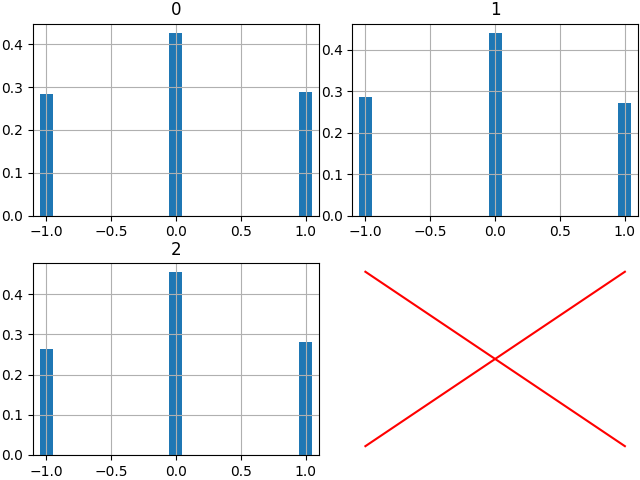

In [118]:
FIG_NAME = "dist"
plt.close(FIG_NAME)

num_plots = len(ds)
ceil_sqrt_num_plots = np.ceil(np.sqrt(num_plots)).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_plots, ceil_sqrt_num_plots, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1
width=0.1
for i, (ax, d) in enumerate(zip(axs, ds + [None]*len(axs))):
    if d is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(0, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(0, 1), '-', color="red")
        ax.axis("off")

    else:
        ax.set_title(i)
        vals = [pair.value for pair in d]
        probs = [pair.probability for pair in d]

        if len(vals) > 3:
            ax.plot(vals, probs, 'o-')
        else:
            ax.bar(vals, probs, width=width)

        min_x = min(min_x, min(vals))
        max_x = max(max_x, max(vals))

for ax in axs:
    ax.set_xlim(min_x-width, max_x+width)
    ax.grid()

fig.tight_layout(pad=0.1)
plt.show()

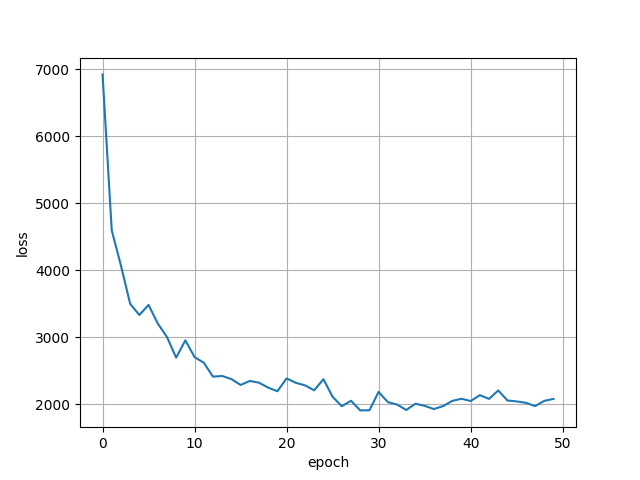

In [92]:
NAME = 'loss_curve_partial'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses[:train_epochs])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

In [93]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, '\n', p, '\n', p.grad)

layers.TernBinLayer0.W 
 Parameter containing:
tensor([[-1,  1,  1,  ..., -1,  1,  0],
        [ 0, -1, -1,  ...,  1, -1,  0],
        [ 1,  1,  0,  ...,  0, -1,  0],
        ...,
        [ 1,  0,  0,  ..., -1,  0,  1],
        [ 1,  0,  0,  ...,  0,  0,  1],
        [ 1,  1, -1,  ...,  0, -1,  0]], dtype=torch.int32) 
 tensor([[ 10, -18,  -9,  ..., -22,  -1,  -2],
        [-24,   0,  13,  ...,  -6, -21,   4],
        [-40,   4,  21,  ...,   4,  -5,   2],
        ...,
        [ 22,   0, -25,  ...,   8,  21,   2],
        [ 16,   8,  -5,  ..., -10,  17,  -4],
        [ -6,   0,  13,  ...,  14,  -1,  -6]], dtype=torch.int32)
layers.TernBinLayer1.W 
 Parameter containing:
tensor([[ 1,  0,  1,  ..., -1, -1,  0],
        [-1,  1,  1,  ...,  0,  0,  0],
        [ 0,  1,  0,  ..., -1, -1, -1],
        ...,
        [ 0,  1,  1,  ..., -1,  0,  0],
        [-1,  1,  1,  ...,  1,  1,  0],
        [-1, -1,  0,  ...,  1,  0,  0]], dtype=torch.int32) 
 tensor([[  4,   2,  -3,  ...,   1,  -2,  10],
 

In [94]:
assert bnn.network.network_params_al_ternary(TBNN)